# Second Hands Prices

This is a review of the AutoTrader data we have regarding second hand vehicle sales. The plots below aim to assist in our understanding of monthly trends in new registrations and the prices of vehicles over time.

Created for New AutoMotive by Corrin Reilly.

Notes:
- Vehicles from the 'Other' category are generally ignored.

## Imports

In [1]:
# Packages
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# Modules
from modules.connector import MyBigQuery

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Initialise Connections

In [3]:
bq = MyBigQuery(
    credentials_file='./credentials/New AutoMotive Index-487e031dc242.json'
)

## Gather Data

In [4]:
df_sh = bq.from_bq_to_dataframe(
    query="""
    WITH earliest_dos AS (
        SELECT
            id,
            MIN(dos) AS earliest_dos
        FROM `rugged-baton-283921.second_hand.autotrader`
        GROUP BY
            id
    )

    SELECT
        FORMAT_DATE('%Y-%m', DATE(dos)) AS month,
        CASE
            WHEN t.fuelType IN ('Hydrogen', 'nan', 'Bi Fuel', 'None') THEN 'Other'
            WHEN t.fuelType IN ('Petrol Hybrid', 'Petrol Plug-in Hybrid', 'Diesel Plug-in Hybrid', 'Diesel Hybrid') THEN 'Hybrid'
            ELSE t.fuelType
        END AS ft,
        MIN(price) as min_price,
        MAX(price) as max_price,
        AVG(price) as avg_price,
        APPROX_QUANTILES(price, 2)[OFFSET(1)] AS median_price,
        COUNT(t.fuelType) AS registrations
    FROM `rugged-baton-283921.second_hand.autotrader` AS t
    JOIN earliest_dos AS ed ON t.id = ed.id AND t.dos = ed.earliest_dos
    GROUP BY
        month, ft
    ORDER BY
        month, ft ASC;
    """
)
df_sh.set_index('month', inplace=True)
df_sh.head()

,ft,min_price,max_price,avg_price,median_price,registrations
month,,,,,,
2022-12,Diesel,390.0,556950.0,20315.275673,15900.0,234488
2022-12,Electric,5995.0,179999.0,41034.287954,34994.0,12693
2022-12,Hybrid,2395.0,179995.0,32819.671634,28235.0,48446
2022-12,Other,1495.0,749995.0,23971.481203,11995.0,133
2022-12,Petrol,380.0,1000000.0,20107.689402,16138.0,272185


## Define Constants

In [5]:
# Define fuel type colours.
colors = {
    'Hybrid': 'blue',
    'Diesel': 'black',
    'Petrol': 'grey',
    'Electric': 'green'
}
fuelTypes = ['Electric', 'Hybrid', 'Petrol', 'Diesel']

## Prepare Data for Plotting

In [6]:
# Copy data to new DataFrame.
df_sh_prop = df_sh.copy()

totals = {}

# Calculate the total number of registrations for each month.
for date in df_sh_prop.index.unique():
    df_date = df_sh_prop[df_sh_prop.index == date].copy()
    total = df_date.registrations.sum()
    totals[date] = total

In [7]:
# Update DataFrame to have a column for the total registrations for that month.
for index, row in df_sh_prop.iterrows():
    if index in totals:
        df_sh_prop.loc[index, 'sum'] = totals[index]

df_sh_prop.head()

,ft,min_price,max_price,avg_price,median_price,registrations,sum
month,,,,,,,
2022-12,Diesel,390.0,556950.0,20315.275673,15900.0,234488,567945.0
2022-12,Electric,5995.0,179999.0,41034.287954,34994.0,12693,567945.0
2022-12,Hybrid,2395.0,179995.0,32819.671634,28235.0,48446,567945.0
2022-12,Other,1495.0,749995.0,23971.481203,11995.0,133,567945.0
2022-12,Petrol,380.0,1000000.0,20107.689402,16138.0,272185,567945.0


In [8]:
# Create a column that shows the proportion (%) of the months registrations that fuel type accounts for.
df_sh_prop['proportion'] = df_sh_prop.apply(lambda x: (100 * x['registrations']) / x['sum'] if x['sum'] != 0 else 0, axis=1)
df_sh_prop.head()

,ft,min_price,max_price,avg_price,median_price,registrations,sum,proportion
month,,,,,,,,
2022-12,Diesel,390.0,556950.0,20315.275673,15900.0,234488,567945.0,41.287096
2022-12,Electric,5995.0,179999.0,41034.287954,34994.0,12693,567945.0,2.234900
2022-12,Hybrid,2395.0,179995.0,32819.671634,28235.0,48446,567945.0,8.530051
2022-12,Other,1495.0,749995.0,23971.481203,11995.0,133,567945.0,0.023418
2022-12,Petrol,380.0,1000000.0,20107.689402,16138.0,272185,567945.0,47.924535


## Create Plots

### No. of New Registrations by Fuel Type and Month

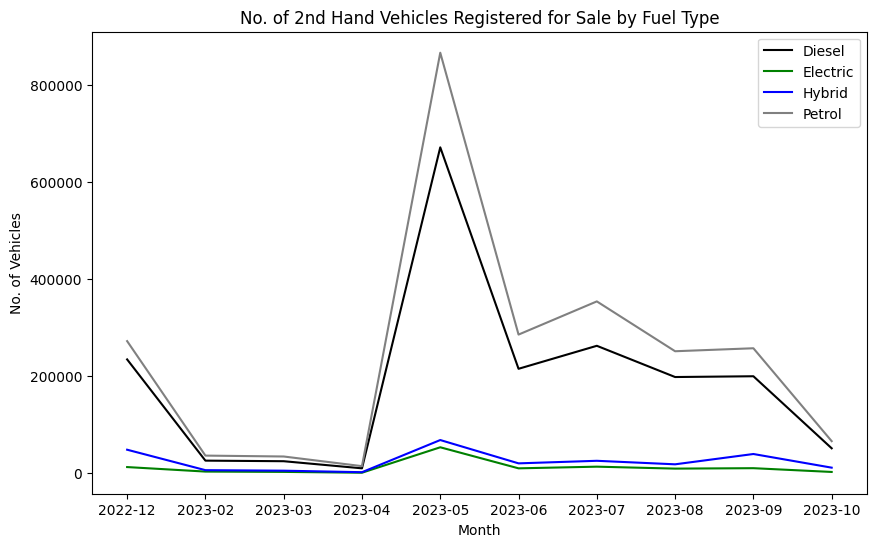

In [9]:
# Create the plot.
fig, ax = plt.subplots(figsize=(10, 6))

# Define plot for each fuel type.
for ft in df_sh.ft.unique():
    if ft != 'Other':
        df_plot = df_sh.query(f'ft == "{ft}"').copy()
        ax.plot(df_plot.index, df_plot.registrations, label=ft, color=colors[ft])

# Labels.
ax.set_xlabel('Month')
ax.set_ylabel('No. of Vehicles')
ax.set_title('No. of 2nd Hand Vehicles Registered for Sale by Fuel Type')

# Show legend.
ax.legend()

# Show the plot.
plt.show()

### Monthly Difference in New Registrations.

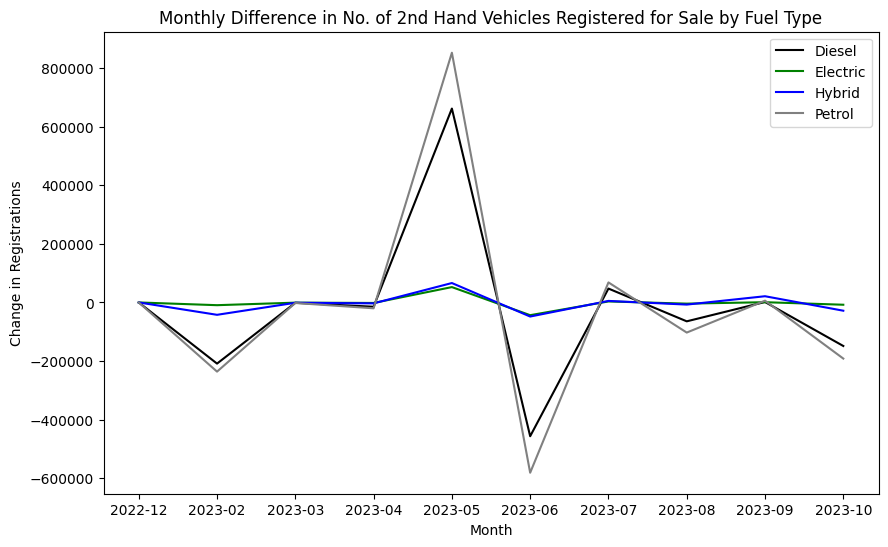

In [10]:
# Create the plot.
fig, ax = plt.subplots(figsize=(10, 6))

# Define plot for each fuel type.
for ft in df_sh.ft.unique():
    if ft != 'Other':
        df_plot = df_sh.query(f'ft == "{ft}"').copy()
        df_plot['diff'] = df_plot['registrations'].diff()
        df_plot['diff'].fillna(0, inplace=True)
        ax.plot(df_plot.index, df_plot['diff'], label=ft, color=colors[ft])

# Labels.
ax.set_xlabel('Month')
ax.set_ylabel('Change in Registrations')
ax.set_title('Monthly Difference in No. of 2nd Hand Vehicles Registered for Sale by Fuel Type')

# Show legend.
ax.legend()

# Show the plot.
plt.show()

### Proportion of Each Fuel Type as New Registrations

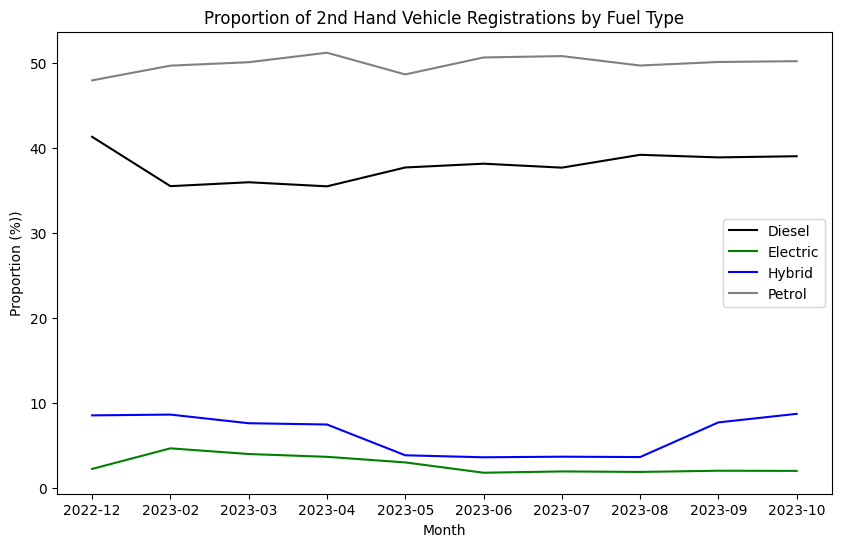

In [11]:
# Create the plot.
fig, ax = plt.subplots(figsize=(10, 6))

# Define plot for each fuel type.
for ft in df_sh_prop.ft.unique():
    if ft != 'Other':
        df_plot = df_sh_prop.query(f'ft == "{ft}"').copy()
        ax.plot(df_plot.index, df_plot.proportion, label=ft, color=colors[ft])

# Labels.
ax.set_xlabel('Month')
ax.set_ylabel('Proportion (%))')
ax.set_title('Proportion of 2nd Hand Vehicle Registrations by Fuel Type')

# Show legend.
ax.legend()

# Show the plot.
plt.show()

### Avg. Price of New Registrations by Fuel Type

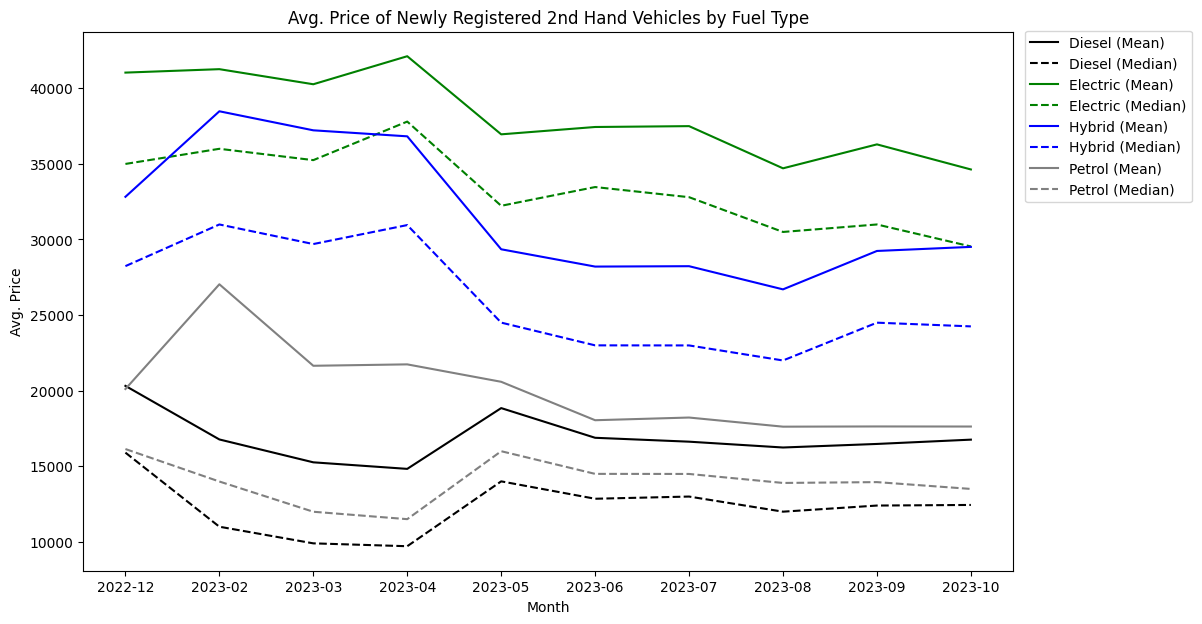

In [12]:
# Create the plot.
fig, ax = plt.subplots(figsize=(12, 7))

# Define plot for each fuel type.
for ft in df_sh_prop.ft.unique():
    if ft != 'Other':
        df_plot = df_sh_prop.query(f'ft == "{ft}"').copy()
        ax.plot(df_plot.index, df_plot.avg_price, label=ft + ' (Mean)', color=colors[ft])
        ax.plot(df_plot.index, df_plot.median_price, label=ft + ' (Median)', color=colors[ft], linestyle='dashed')

# Labels
ax.set_xlabel('Month')
ax.set_ylabel('Avg. Price')
ax.set_title('Avg. Price of Newly Registered 2nd Hand Vehicles by Fuel Type')

# Show legend
ax.legend(bbox_to_anchor=(1.2, 1.015), loc='upper right')

plt.show()

### Plot of Median and Min. Prices of Fuel Types

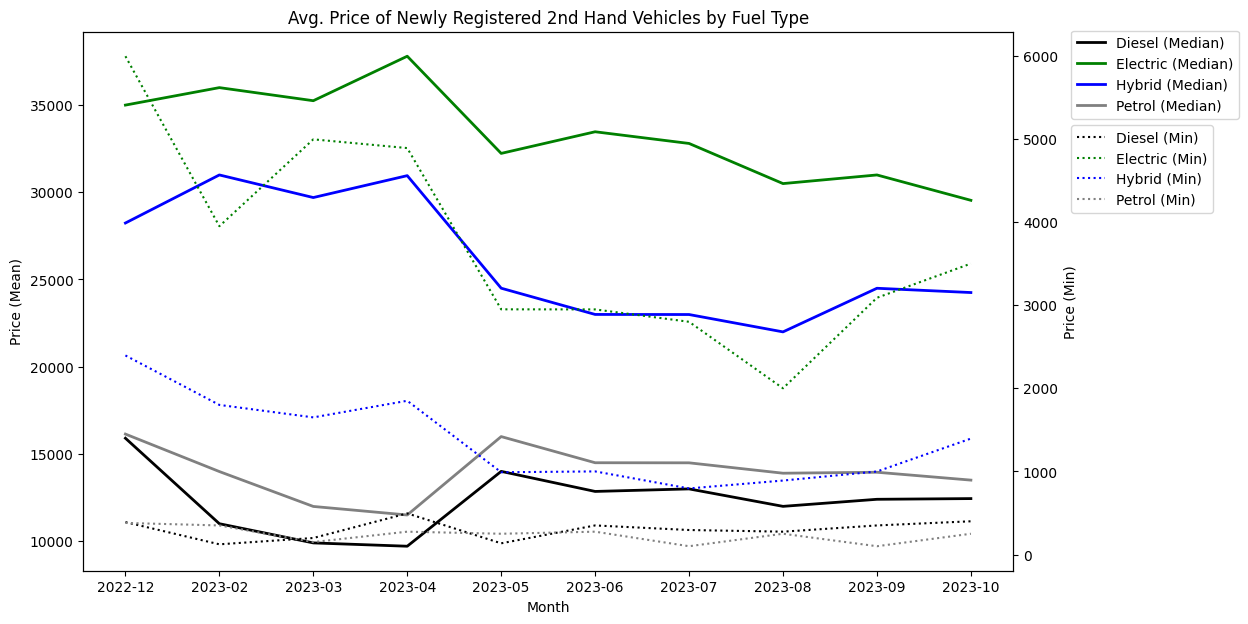

In [13]:
# Create the plot.
fig, ax = plt.subplots(figsize=(12, 7))

ax2 = ax.twinx()
ax2.set_ylabel('Price (Min)')

# Define plot for each fuel type.
for ft in df_sh_prop.ft.unique():
    if ft != 'Other':
        df_plot = df_sh_prop.query(f'ft == "{ft}"').copy()
        ax.plot(df_plot.index, df_plot.median_price, label=ft + ' (Median)', color=colors[ft], linewidth=2)
        ax2.plot(df_plot.index, df_plot.min_price, label=ft + ' (Min)', color=colors[ft], linestyle=':')

# Labels
ax.set_xlabel('Month')
ax.set_ylabel('Price (Mean)')
ax.set_title('Avg. Price of Newly Registered 2nd Hand Vehicles by Fuel Type')

# Show legend
ax.legend(bbox_to_anchor=(1.25, 1.015), loc='upper right')
ax2.legend(bbox_to_anchor=(1.222, 0.84), loc='upper right')

plt.show()

### Plot of Median and Max. Prices of Fuel Types

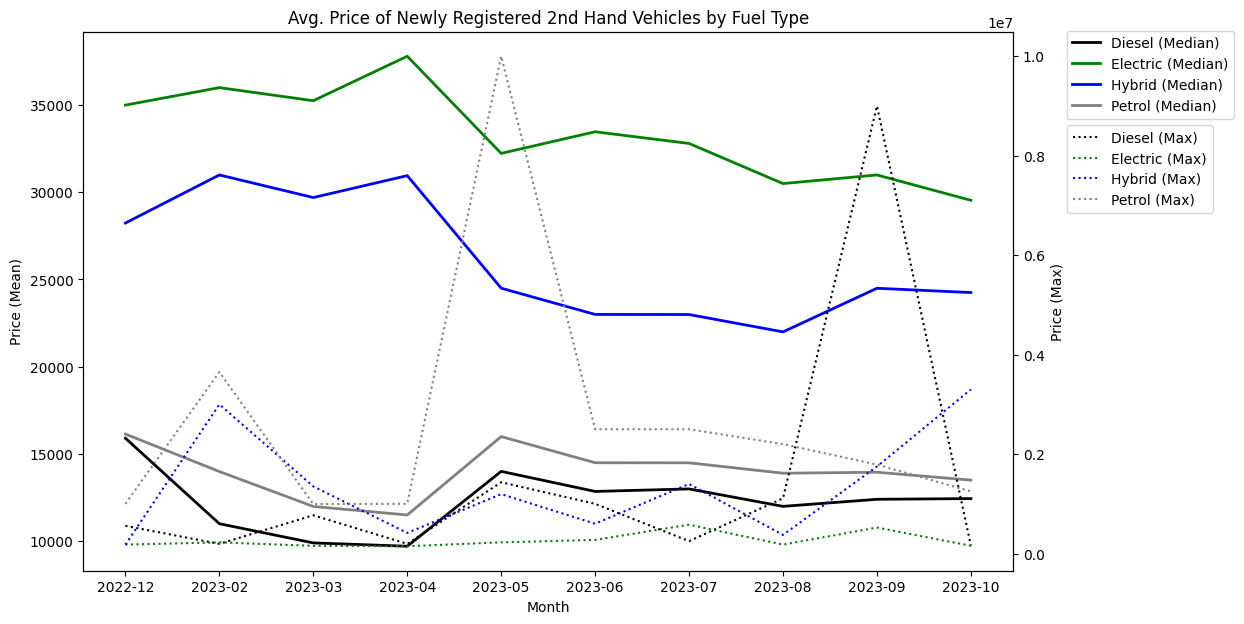

In [14]:
# Create the plot.
fig, ax = plt.subplots(figsize=(12, 7))

ax2 = ax.twinx()
ax2.set_ylabel('Price (Max)')

# Define plot for each fuel type.
for ft in df_sh_prop.ft.unique():
    if ft != 'Other':
        df_plot = df_sh_prop.query(f'ft == "{ft}"').copy()
        ax.plot(df_plot.index, df_plot.median_price, label=ft + ' (Median)', color=colors[ft], linewidth=2)
        ax2.plot(df_plot.index, df_plot.max_price, label=ft + ' (Max)', color=colors[ft], linestyle=':')

# Labels.
ax.set_xlabel('Month')
ax.set_ylabel('Price (Mean)')
ax.set_title('Avg. Price of Newly Registered 2nd Hand Vehicles by Fuel Type')

# Show legend.
ax.legend(bbox_to_anchor=(1.245, 1.015), loc='upper right')
ax2.legend(bbox_to_anchor=(1.222, 0.84), loc='upper right')

# Show the plot.
plt.show()

## Projections: Linear Regression

In [15]:
df_lr = df_sh_prop.copy()
df_lr.index = pd.to_datetime(df_lr.index, format="%Y-%m")
df_lr.head()

,ft,min_price,max_price,avg_price,median_price,registrations,sum,proportion
month,,,,,,,,
2022-12-01,Diesel,390.0,556950.0,20315.275673,15900.0,234488,567945.0,41.287096
2022-12-01,Electric,5995.0,179999.0,41034.287954,34994.0,12693,567945.0,2.234900
2022-12-01,Hybrid,2395.0,179995.0,32819.671634,28235.0,48446,567945.0,8.530051
2022-12-01,Other,1495.0,749995.0,23971.481203,11995.0,133,567945.0,0.023418
2022-12-01,Petrol,380.0,1000000.0,20107.689402,16138.0,272185,567945.0,47.924535


In [16]:
df_lr_petrol = df_lr.query('ft == "Petrol"').copy()

X = sm.add_constant(df_lr_petrol.index.to_julian_date(), has_constant='add')

petrol_model = sm.OLS(df_lr_petrol['median_price'], X).fit()

petrol_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           median_price   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.105
Method:                 Least Squares   F-statistic:                    0.1421
Date:                Mon, 09 Oct 2023   Prob (F-statistic):              0.716
Time:                        10:35:42   Log-Likelihood:                -86.540
No. Observations:                  10   AIC:                             177.1
Df Residuals:                       8   BIC:                             177.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.936e+06   1.31e+07      0.378      0.715   -2.52e+07    3.51e+07
x1            -2.0009      5.309     -0.377      0.716     -14.243      10.241
==============================================================================
Omnibus:                        0.817   Durbin-Watson:                   1.627
Prob(Omnibus):                  0.665   Jarque-Bera (JB):                0.512
Skew:                          -0.491   Prob(JB):                        0.774
Kurtosis:                       2.485   Cond. No.                     6.55e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.55e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
df_lr = bq.from_bq_to_dataframe(
    query="""
    WITH earliest_dos AS (
        SELECT
            id,
            MIN(dos) AS earliest_dos
        FROM `rugged-baton-283921.second_hand.autotrader`
        GROUP BY
            id
    )

    SELECT
        DATE(dos) AS date,
        CASE
            WHEN t.fuelType IN ('Hydrogen', 'nan', 'Bi Fuel', 'None') THEN 'Other'
            WHEN t.fuelType IN ('Petrol Hybrid', 'Petrol Plug-in Hybrid', 'Diesel Plug-in Hybrid', 'Diesel Hybrid') THEN 'Hybrid'
            ELSE t.fuelType
        END AS ft,
        MIN(price) as min_price,
        MAX(price) as max_price,
        AVG(price) as avg_price,
        APPROX_QUANTILES(price, 2)[OFFSET(1)] AS median_price,
        COUNT(t.fuelType) AS registrations
    FROM `rugged-baton-283921.second_hand.autotrader` AS t
    JOIN earliest_dos AS ed ON t.id = ed.id AND t.dos = ed.earliest_dos
    GROUP BY
        date, ft
    ORDER BY
        date, ft ASC;
    """
)
df_lr.head(10)

,date,ft,min_price,max_price,avg_price,median_price,registrations
0,2022-12-15,Diesel,390.0,556950.0,20315.275673,15995.0,234488
1,2022-12-15,Electric,5995.0,179999.0,41034.287954,34999.0,12693
2,2022-12-15,Hybrid,2395.0,179995.0,32819.671634,28199.0,48446
3,2022-12-15,Other,1495.0,749995.0,23971.481203,11995.0,133
4,2022-12-15,Petrol,380.0,1000000.0,20107.689402,16200.0,272185
5,2023-02-27,Diesel,123.0,195000.0,16771.422053,11000.0,25947
6,2023-02-27,Electric,3950.0,225000.0,41261.425676,35995.0,3404
7,2023-02-27,Hybrid,1800.0,2999830.0,38476.291468,30925.0,6306
8,2023-02-27,Other,189.0,1500000.0,16307.942907,605.0,1156
9,2023-02-27,Petrol,350.0,3650000.0,27034.205591,13970.0,36310


In [18]:
df_lr['date'] = pd.to_datetime(df_lr['date'])
df_lr = df_lr.sort_values(by='date')

In [19]:
ft_categories = df_lr['ft'].unique()

In [20]:
def time_series_analysis(df: pd.DataFrame, ft_category: str, column):
    # Filter the DataFrame for the specific 'ft' category.
    df_ft = df.query(f"ft == '{ft_category}'")
    
    # Extract the date and median_price columns.
    dates = df_ft['date']
    column_values = df_ft[column]
    
    start_date = dates.min()
    latest_date = dates.max()
    days_since_start = np.array([(date - start_date).days for date in dates])
    
    # # Create a DataFrame to store predictions.
    # df_predictions = pd.DataFrame(columns=['date', column])
    
    # Set train and test sets for the model.
    x_train, x_test, y_train, y_test = train_test_split(days_since_start, column_values, train_size=0.9, random_state=50)
    
    # Create a linear regression model.
    model = LinearRegression()
    model.fit(x_train.reshape(-1, 1), y_train)
    
    print("Intercept: ", model.intercept_)
    print("Coefficients:", list(zip(days_since_start, model.coef_)))
    
    # Use the test_x values to get predictions for y.
    y_pred_regression = model.predict(np.array(x_test).reshape(-1, 1))
    print(y_pred_regression)
    
    # Check the difference in values between the actual values and predictions.
    regression_diff = pd.DataFrame({'actual': y_test, 'prediction': y_pred_regression})
    print(regression_diff.head())
    
    meanAbError = mean_absolute_error(y_test, y_pred_regression)
    meanSqError = mean_squared_error(y_test, y_pred_regression)
    rootMeanSqError = np.sqrt(meanSqError)
    
    print('R squared: {:.2f}'.format(model.score(days_since_start.reshape(-1, 1), column_values) * 100))
    print('Mean Absolute Error:', meanAbError)
    print('Mean Square Error:', meanSqError)
    print('Root Mean Square Error:', rootMeanSqError)
    
    future_dates = pd.date_range(start=latest_date, freq='W', periods=105)[1:]
    future_days_from_start = np.array([(date - start_date).days for date in future_dates])
    
    predictions = model.predict(future_days_from_start.reshape(-1, 1))
    
    # Create a DataFrame to store predictions.
    df_predictions = pd.DataFrame({'date': future_dates, column: predictions})
    
    # Iterate over weeks for prediction.
    # latest_date = df['date'].max()
    # for i in range(1, 105):
    #     # Calculate the prediction date.
    #     prediction_date = latest_date + timedelta(weeks=i)
        
    #     # Fit the model on available data.
    #     X = (dates - latest_date).dt.days.values.reshape(-1, 1)
    #     y = column_values.values
    #     model.fit(X, y)
    #     if i == 1:
    #         print('R squared: {:.2f}'.format(model.score(X, y) * 100))
        
    #     # Make a prediction for the future date.
    #     prediction_days = (prediction_date - latest_date).days
    #     predicted_value = model.predict([[prediction_days]])[0]
        
    #     # Append the prediction to the DataFrame.
    #     df_predictions = df_predictions.append({'date': prediction_date, column: predicted_value}, ignore_index=True)
    
    return df_predictions

In [21]:
predicted_dfs = {}
for ft_category in ft_categories:
    # Conduct analysis and append to predicted_dfs.
    predictions_df = time_series_analysis(df_lr, ft_category, 'median_price')
    predicted_dfs[ft_category] = predictions_df

Intercept:  11372.954297915418
Coefficients: [(0, 3.8521773533299504)]
[12170.35501005 11939.22436885 12466.97266626]
      actual    prediction
85   12999.0  12170.355010
40   14695.0  11939.224369
140  12494.0  12466.972666
R squared: 1.90
Mean Absolute Error: 1203.8159849430795
Mean Square Error: 2760560.775114503
Root Mean Square Error: 1661.4935374880347
Intercept:  37878.461468857815
Coefficients: [(0, -26.66198539131072)]
[32359.43049286 33959.14961634 30306.45761773]
      actual    prediction
86   32990.0  32359.430493
41   31950.0  33959.149616
141  30000.0  30306.457618
R squared: 67.22
Mean Absolute Error: 982.0589137347391
Mean Square Error: 1509405.4518736254
Root Mean Square Error: 1228.5786307248004
Intercept:  31229.368809945256
Coefficients: [(0, -34.683688030845666)]
[24049.84538756 26130.86666941 21379.20140919]
      actual    prediction
87   23450.0  24049.845388
42   25714.0  26130.866669
142  24495.0  21379.201409
R squared: 58.79
Mean Absolute Error: 1377.50354

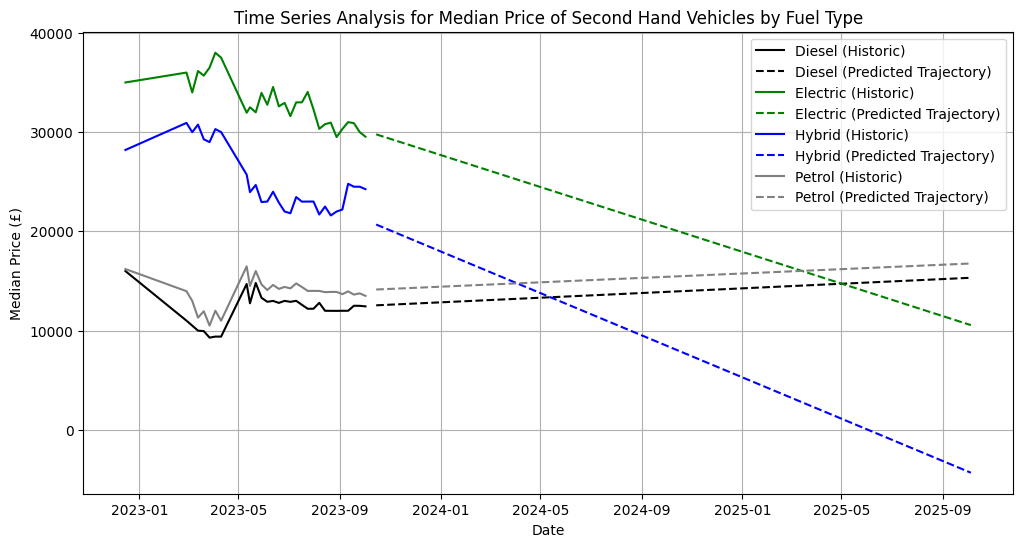

In [22]:
plt.figure(figsize=(12, 6))

# Iterate over each 'ft' category and plot the current data along with predictions.
for ft_category in ft_categories:
    if ft_category != 'Other':
        # Filter the original DataFrame for the specific 'ft' category.
        df_ft = df_lr[df_lr['ft'] == ft_category]
        
        # Get the corresponding predictions DataFrame.
        predictions_df = predicted_dfs[ft_category]
        
        # Plot the current data.
        plt.plot(df_ft['date'], df_ft['median_price'], label=f'{ft_category} (Historic)', linestyle='-', markersize=5, color=colors[ft_category])
        
        # Plot the predictions.
        plt.plot(predictions_df['date'], predictions_df['median_price'], label=f'{ft_category} (Predicted Trajectory)', linestyle='--', color=colors[ft_category])

# Set labels and legend.
plt.xlabel('Date')
plt.ylabel('Median Price (£)')
plt.title('Time Series Analysis for Median Price of Second Hand Vehicles by Fuel Type')
plt.legend()

# Show the plot.
plt.grid(True)
plt.show()

In [23]:
# Create a figure.
fig = go.Figure()

# Iterate over each 'ft' category and add the current data and predictions to the figure.
for ft_category in ft_categories:
    if ft_category != 'Other':
        # Filter the original DataFrame for the specific 'ft' category.
        df_ft = df_lr[df_lr['ft'] == ft_category]
        
        # Get the corresponding predictions DataFrame.
        predictions_df = predicted_dfs[ft_category]
        
        # Add current data as a scatter plot.
        fig.add_trace(
            go.Scatter(
                x=df_ft['date'],
                y=df_ft['median_price'],
                mode='lines',
                name=f'Current Data ({ft_category})',
                line=dict(color=colors[ft_category])
            )
        )
        
        # Add predictions as a line plot.
        fig.add_trace(
            go.Scatter(
                x=predictions_df['date'],
                y=predictions_df['median_price'],
                mode='lines',
                name=f'Predictions ({ft_category})',
                line=dict(dash='dash', color=colors[ft_category])
            )
        )
    
# Update layout.
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Median Price (£)',
    title='Time Series Analysis for Median Price of Second Hand Vehicles by Fuel Type',
    showlegend=True,
)

# Show the plot.
fig.show()

<hr />

## Price Per Mile Analysis

In [24]:
df_ppm = bq.from_bq_to_dataframe(
    query="""
    WITH earliest_dos AS (
        SELECT
            id,
            MIN(dos) AS earliest_dos
        FROM `rugged-baton-283921.second_hand.autotrader`
        GROUP BY
            id
    )
    SELECT
        DATE(dos) AS date,
        CASE
            WHEN t.fuelType IN ('Hydrogen', 'nan', 'Bi Fuel', 'None') THEN 'Other'
            WHEN t.fuelType IN ('Petrol Hybrid', 'Petrol Plug-in Hybrid', 'Diesel Plug-in Hybrid', 'Diesel Hybrid') THEN 'Hybrid'
            ELSE t.fuelType
        END AS ft,
        COUNT(t.fuelType) AS registrations,
        MIN(price) as min_price,
        MIN(price) / AVG(mileage) as min_price_per_mile,
        MAX(price) as max_price,
        MAX(price) / AVG(mileage) as max_price_per_mile,
        AVG(price) as avg_price,
        AVG(price) / AVG(mileage) as avg_price_per_mile,
        APPROX_QUANTILES(price, 2)[OFFSET(1)] AS median_price,
        APPROX_QUANTILES(price, 2)[OFFSET(1)] / AVG(mileage) AS median_price_per_mile,
    FROM `rugged-baton-283921.second_hand.autotrader` AS t
    JOIN earliest_dos AS ed ON t.id = ed.id AND t.dos = ed.earliest_dos
    GROUP BY
        date, ft
    ORDER BY
        date, ft ASC;
    """
)
df_ppm.head(10)

,date,ft,registrations,min_price,min_price_per_mile,max_price,max_price_per_mile,avg_price,avg_price_per_mile,median_price,median_price_per_mile
0,2022-12-15,Diesel,234488,390.0,0.006370,556950.0,9.096487,20315.275673,0.331803,15990.0,0.261160
1,2022-12-15,Electric,12693,5995.0,0.455759,179999.0,13.684092,41034.287954,3.119556,34940.0,2.656249
2,2022-12-15,Hybrid,48446,2395.0,0.104774,179995.0,7.874261,32819.671634,1.435766,27999.0,1.224875
3,2022-12-15,Other,133,1495.0,0.021049,749995.0,10.559443,23971.481203,0.337503,12895.0,0.181553
4,2022-12-15,Petrol,272185,380.0,0.010455,1000000.0,27.512499,20107.689402,0.553213,16000.0,0.440200
5,2023-02-27,Diesel,25947,123.0,0.001685,195000.0,2.671274,16771.422053,0.229749,10995.0,0.150619
6,2023-02-27,Electric,3404,3950.0,0.253611,225000.0,14.446178,41261.425676,2.649200,36215.0,2.325193
7,2023-02-27,Hybrid,6306,1800.0,0.058795,2999830.0,97.986437,38476.291468,1.256789,30791.0,1.005757
8,2023-02-27,Other,1156,189.0,0.004056,1500000.0,32.193845,16307.942907,0.350010,598.0,0.012835
9,2023-02-27,Petrol,36310,350.0,0.007337,3650000.0,76.515282,27034.205591,0.566721,13979.0,0.293043


In [25]:
df_ppm['date'] = pd.to_datetime(df_ppm['date'])
df_ppm = df_ppm.sort_values(by='date')

In [26]:
predicted_dfs_ppm = {}
for ft_category in ft_categories:
    # Conduct analysis and append to predicted_dfs_ppm.
    predictions_df_ppm = time_series_analysis(df_ppm, ft_category, 'median_price_per_mile')
    predicted_dfs_ppm[ft_category] = predictions_df_ppm

Intercept:  0.1633789457200576
Coefficients: [(0, 5.564217044508654e-05)]
[0.17489688 0.17155834 0.17918132]
       actual  prediction
85   0.191643    0.174897
40   0.235590    0.171558
140  0.180777    0.179181
R squared: 0.27
Mean Absolute Error: 0.027457651004873518
Mean Square Error: 0.0014610005252802512
Root Mean Square Error: 0.03822303657848564
Intercept:  2.7114430680352135
Coefficients: [(0, -0.0026309478629347395)]
[2.16683686 2.32469373 1.96425387]
       actual  prediction
86   2.370101    2.166837
41   2.547582    2.324694
141  1.830025    1.964254
R squared: 47.61
Mean Absolute Error: 0.18679378355266682
Mean Square Error: 0.03633764238882952
Root Mean Square Error: 0.19062434888762117
Intercept:  1.0187419005543747
Coefficients: [(0, -0.0011575660180716772)]
[0.77912573 0.8485797  0.68999315]
       actual  prediction
87   0.839642    0.779126
42   0.870528    0.848580
142  0.949262    0.689993
R squared: 23.31
Mean Absolute Error: 0.11391115611802564
Mean Square Error

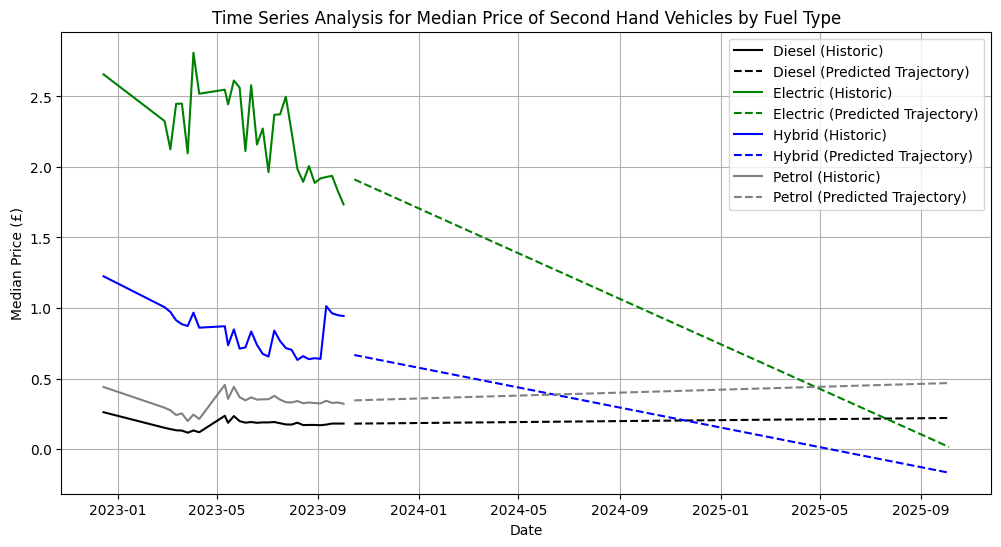

In [27]:
plt.figure(figsize=(12, 6))

# Iterate over each 'ft' category and plot the current data along with predictions.
for ft_category in ft_categories:
    if ft_category != 'Other':
        # Filter the original DataFrame for the specific 'ft' category.
        df_ft = df_ppm[df_ppm['ft'] == ft_category]
        
        # Get the corresponding predictions DataFrame.
        predictions_df = predicted_dfs_ppm[ft_category]
        
        # Plot the current data.
        plt.plot(df_ft['date'], df_ft['median_price_per_mile'], label=f'{ft_category} (Historic)', linestyle='-', markersize=5, color=colors[ft_category])
        
        # Plot the predictions.
        plt.plot(predictions_df['date'], predictions_df['median_price_per_mile'], label=f'{ft_category} (Predicted Trajectory)', linestyle='--', color=colors[ft_category])

# Set labels and legend.
plt.xlabel('Date')
plt.ylabel('Median Price (£)')
plt.title('Time Series Analysis for Median Price of Second Hand Vehicles by Fuel Type')
plt.legend()

# Show the plot.
plt.grid(True)
plt.show()

<hr />

## Multiple Regression

In [28]:
df_mr = bq.from_bq_to_dataframe(
    query="""
    WITH earliest_dos AS (
        SELECT
            id,
            MIN(dos) AS earliest_dos
        FROM `rugged-baton-283921.second_hand.autotrader`
        GROUP BY
            id
    )
    SELECT
        DATE(dos) AS date,
        CASE
            WHEN t.fuelType IN ('Hydrogen', 'nan', 'Bi Fuel', 'None') THEN 'Other'
            WHEN t.fuelType IN ('Petrol Hybrid', 'Petrol Plug-in Hybrid', 'Diesel Plug-in Hybrid', 'Diesel Hybrid') THEN 'Hybrid'
            ELSE t.fuelType
        END AS ft,
        COUNT(t.fuelType) AS registrations,
        MIN(price) as min_price,
        MIN(price) / AVG(mileage) as min_price_per_mile,
        MAX(price) as max_price,
        MAX(price) / AVG(mileage) as max_price_per_mile,
        AVG(price) as avg_price,
        AVG(price) / AVG(mileage) as avg_price_per_mile,
        APPROX_QUANTILES(price, 2)[OFFSET(1)] AS median_price,
        APPROX_QUANTILES(price, 2)[OFFSET(1)] / AVG(mileage) AS median_price_per_mile,
    FROM `rugged-baton-283921.second_hand.autotrader` AS t
    JOIN earliest_dos AS ed ON t.id = ed.id AND t.dos = ed.earliest_dos
    GROUP BY
        date, ft
    ORDER BY
        date, ft ASC;
    """
)
df_mr['date'] = pd.to_datetime(df_mr['date'], format='%Y-%m-%d')
df_mr.head()

,date,ft,registrations,min_price,min_price_per_mile,max_price,max_price_per_mile,avg_price,avg_price_per_mile,median_price,median_price_per_mile
0,2022-12-15,Diesel,234488,390.0,0.006370,556950.0,9.096487,20315.275673,0.331803,15990.0,0.261160
1,2022-12-15,Electric,12693,5995.0,0.455759,179999.0,13.684092,41034.287954,3.119556,34940.0,2.656249
2,2022-12-15,Hybrid,48446,2395.0,0.104774,179995.0,7.874261,32819.671634,1.435766,27999.0,1.224875
3,2022-12-15,Other,133,1495.0,0.021049,749995.0,10.559443,23971.481203,0.337503,12895.0,0.181553
4,2022-12-15,Petrol,272185,380.0,0.010455,1000000.0,27.512499,20107.689402,0.553213,16000.0,0.440200


In [29]:
# Define important dates for analysis.
dates = df_mr['date']
start_date = dates.min()
latest_date = dates.max()

df_mr['days_since_start'] = [(date - start_date).days for date in dates]

In [30]:
# Method for running multiple linear regressions.
def generate_multiple_regression(df: pd.DataFrame, fuelType: str, x_columns: [], train_size: float):
    df_ft = df.query(f"ft == '{fuelType}'").copy()
    
    # Set independent and dependent variables.
    x = df_ft[x_columns]
    y = df_ft['median_price']
    
    # Get training and testing sets of each variable on an 80/20 split.
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=train_size, random_state=50)
    
    # Set regression model.
    regression = LinearRegression()
    regression.fit(x_train, y_train)
    
    print("Intercept: ", regression.intercept_)
    print("Coefficients:", list(zip(x, regression.coef_)))
    
    # Use the test_x values to get predictions for y.
    y_pred_regression = regression.predict(x_test)
    print(y_pred_regression)
    
    # Check the difference in values between the actual values and predictions.
    regression_diff = pd.DataFrame({'actual': y_test, 'prediction': y_pred_regression})
    print(regression_diff.head())
    
    meanAbError = mean_absolute_error(y_test, y_pred_regression)
    meanSqError = mean_squared_error(y_test, y_pred_regression)
    rootMeanSqError = np.sqrt(meanSqError)
    
    print('R squared: {:.2f}'.format(regression.score(x, y) * 100))
    print('Mean Absolute Error:', meanAbError)
    print('Mean Square Error:', meanSqError)
    print('Root Mean Square Error:', rootMeanSqError)
    
    return regression

In [31]:
# Get regression model for EVs.
regression_electric = generate_multiple_regression(df_mr, 'Electric', ['days_since_start', 'registrations', 'median_price_per_mile', 'min_price_per_mile', 'max_price_per_mile'], 0.85)

Intercept:  29643.26781782403
Coefficients: [('days_since_start', -22.40043542846707), ('registrations', -0.2374097431045985), ('median_price_per_mile', 4275.801675418637), ('min_price_per_mile', -4910.993773837633), ('max_price_per_mile', 10.991333348851336)]
[33170.91899085 29959.96278271 29663.13255301 35221.56497452
 33337.47037693]
      actual    prediction
86   32990.0  33170.918991
41   31940.0  29959.962783
141  30000.0  29663.132553
46   32500.0  35221.564975
91   32999.0  33337.470377
R squared: 84.94
Mean Absolute Error: 1111.571801316645
Mean Square Error: 2317647.3693042276
Root Mean Square Error: 1522.3821364244352


In [32]:
# Get regression model for hybrids.
regression_hybrid = generate_multiple_regression(df_mr, 'Hybrid', ['days_since_start', 'registrations', 'median_price_per_mile', 'min_price_per_mile', 'max_price_per_mile'], 0.8)

Intercept:  18342.80158162371
Coefficients: [('days_since_start', -22.217651381073797), ('registrations', -0.16234369480527297), ('median_price_per_mile', 14316.593034328407), ('min_price_per_mile', 3399.97489997791), ('max_price_per_mile', 4.227346709848281)]
[25077.86670152 23116.11293361 23948.1690496  25190.78233153
 23895.79450251 23111.16490912]
      actual    prediction
87   23450.0  25077.866702
42   25545.0  23116.112934
142  24495.0  23948.169050
47   23949.0  25190.782332
92   22990.0  23895.794503
R squared: 88.79
Mean Absolute Error: 1143.8877435784573
Mean Square Error: 1870589.0790044533
Root Mean Square Error: 1367.6948047735114


In [33]:
# Get regression model for petrols.
regression_petrol = generate_multiple_regression(df_mr, 'Petrol', ['days_since_start', 'registrations', 'median_price_per_mile', 'min_price_per_mile', 'max_price_per_mile'], 0.8)

Intercept:  5502.609610716351
Coefficients: [('days_since_start', -1.4037192087172348), ('registrations', -0.004548094043068281), ('median_price_per_mile', 26506.11463027388), ('min_price_per_mile', 5710.388717054116), ('max_price_per_mile', 4.940529647695138)]
[15163.93464929 17165.330847   13780.61853006 14654.69262897
 14420.67882063 13845.98693855]
      actual    prediction
89   14750.0  15163.934649
44   16490.0  17165.330847
144  13750.0  13780.618530
49   14495.0  14654.692629
94   14389.0  14420.678821
R squared: 96.42
Mean Absolute Error: 243.37808956657136
Mean Square Error: 112843.55284644711
Root Mean Square Error: 335.9219445741036


In [34]:
# Get regression model for diesels.
regression_diesel = generate_multiple_regression(df_mr, 'Diesel', ['days_since_start', 'registrations', 'median_price_per_mile', 'min_price_per_mile', 'max_price_per_mile'], 0.8)

Intercept:  2903.5729488121597
Coefficients: [('days_since_start', 0.6132133976492039), ('registrations', -0.0029324611226838188), ('median_price_per_mile', 53382.12806185306), ('min_price_per_mile', -5435.981268633804), ('max_price_per_mile', -0.5506444634912928)]
[13062.84674878 14711.37487649 12545.63557014 12816.64284732
 12635.59972118 12170.63478068]
      actual    prediction
85   12999.0  13062.846749
40   14945.0  14711.374876
140  12494.0  12545.635570
45   12750.0  12816.642847
90   12594.0  12635.599721
R squared: 99.75
Mean Absolute Error: 81.11920504339439
Mean Square Error: 11392.909962999236
Root Mean Square Error: 106.73757521603737


In [35]:
# Conduct a regression for each of the independent variables we are using in the multiple regression model.
electric_tsa_median_price_per_mile = time_series_analysis(df_mr, 'Electric', 'median_price_per_mile')
electric_tsa_registrations = time_series_analysis(df_mr, 'Electric', 'registrations')
electric_tsa_min_price_per_mile = time_series_analysis(df_mr, 'Electric', 'min_price_per_mile')
electric_tsa_max_price_per_mile = time_series_analysis(df_mr, 'Electric', 'max_price_per_mile')

Intercept:  2.7114430680352135
Coefficients: [(0, -0.0026309478629347395)]
[2.16683686 2.32469373 1.96425387]
       actual  prediction
86   2.370101    2.166837
41   2.547582    2.324694
141  1.830025    1.964254
R squared: 47.61
Mean Absolute Error: 0.18679378355266682
Mean Square Error: 0.03633764238882952
Root Mean Square Error: 0.19062434888762117
Intercept:  5011.002926464109
Coefficients: [(0, -9.625353897098845)]
[3018.55466976 3596.07590359 2277.40241969]
     actual   prediction
86     2913  3018.554670
41    24918  3596.075904
141    2698  2277.402420
R squared: 1.35
Mean Absolute Error: 7282.692115495344
Mean Square Error: 151604163.7619727
Root Mean Square Error: 12312.764261609685
Intercept:  0.4196017172933211
Coefficients: [(0, -0.0008164798179838375)]
[0.25059039 0.29957918 0.18772145]
       actual  prediction
86   0.286654    0.250590
41   0.318647    0.299579
141  0.234853    0.187721
R squared: 60.12
Mean Absolute Error: 0.03408766806905505
Mean Square Error: 0.001

In [36]:
# Conduct a regression for each of the independent variables we are using in the multiple regression model.
hybrid_tsa_median_price_per_mile = time_series_analysis(df_mr, 'Hybrid', 'median_price_per_mile')
hybrid_tsa_registrations = time_series_analysis(df_mr, 'Hybrid', 'registrations')
hybrid_tsa_min_price_per_mile = time_series_analysis(df_mr, 'Hybrid', 'min_price_per_mile')
hybrid_tsa_max_price_per_mile = time_series_analysis(df_mr, 'Hybrid', 'max_price_per_mile')

Intercept:  1.0187419005543747
Coefficients: [(0, -0.0011575660180716772)]
[0.77912573 0.8485797  0.68999315]
       actual  prediction
87   0.839642    0.779126
42   0.870528    0.848580
142  0.949262    0.689993
R squared: 23.31
Mean Absolute Error: 0.11391115611802564
Mean Square Error: 0.02378806598797357
Root Mean Square Error: 0.1542338030004239
Intercept:  13104.81417982013
Coefficients: [(0, -32.16884379130706)]
[6445.86351502 8375.9941425  3968.86254309]
     actual   prediction
87     6285  6445.863515
42    29230  8375.994142
142   11416  3968.862543
R squared: 4.63
Mean Absolute Error: 9487.335609810885
Mean Square Error: 163458431.22577348
Root Mean Square Error: 12785.086281514627
Intercept:  0.06826904259876267
Coefficients: [(0, -0.00010529826077370998)]
[0.0464723  0.0527902  0.03836434]
       actual  prediction
87   0.035806    0.046472
42   0.043961    0.052790
142  0.038715    0.038364
R squared: 18.52
Mean Absolute Error: 0.006615386577609399
Mean Square Error: 6.

In [37]:
# Conduct a regression for each of the independent variables we are using in the multiple regression model.
petrol_tsa_median_price_per_mile = time_series_analysis(df_mr, 'Petrol', 'median_price_per_mile')
petrol_tsa_registrations = time_series_analysis(df_mr, 'Petrol', 'registrations')
petrol_tsa_min_price_per_mile = time_series_analysis(df_mr, 'Petrol', 'min_price_per_mile')
petrol_tsa_max_price_per_mile = time_series_analysis(df_mr, 'Petrol', 'max_price_per_mile')

Intercept:  0.2933090257189658
Coefficients: [(0, 0.00017048511425633844)]
[0.32859944 0.31837034 0.3417268 ]
       actual  prediction
89   0.377004    0.328599
44   0.455276    0.318370
144  0.330110    0.341727
R squared: 1.89
Mean Absolute Error: 0.06564237210522295
Mean Square Error: 0.007073723925410655
Root Mean Square Error: 0.08410543338816259
Intercept:  87464.57202730249
Coefficients: [(0, -88.3058036837315)]
[69185.27066477 74483.61888579 62385.72378112]
     actual    prediction
89    79729  69185.270665
44   356567  74483.618886
144   65776  62385.723781
R squared: -0.03
Mean Absolute Error: 98672.46222277108
Mean Square Error: 26564566033.985764
Root Mean Square Error: 162986.39830975395
Intercept:  0.007926605247018801
Coefficients: [(0, -5.5179017781457e-06)]
[0.0067844  0.00711547 0.00635952]
       actual  prediction
89   0.007668    0.006784
44   0.010353    0.007115
144  0.002401    0.006360
R squared: 7.27
Mean Absolute Error: 0.0026933956662608207
Mean Square Err

In [38]:
# Conduct a regression for each of the independent variables we are using in the multiple regression model.
diesel_tsa_median_price_per_mile = time_series_analysis(df_mr, 'Diesel', 'median_price_per_mile')
diesel_tsa_registrations = time_series_analysis(df_mr, 'Diesel', 'registrations')
diesel_tsa_min_price_per_mile = time_series_analysis(df_mr, 'Diesel', 'min_price_per_mile')
diesel_tsa_max_price_per_mile = time_series_analysis(df_mr, 'Diesel', 'max_price_per_mile')

Intercept:  0.1633789457200576
Coefficients: [(0, 5.564217044508654e-05)]
[0.17489688 0.17155834 0.17918132]
       actual  prediction
85   0.191643    0.174897
40   0.235590    0.171558
140  0.180777    0.179181
R squared: 0.27
Mean Absolute Error: 0.027457651004873518
Mean Square Error: 0.0014610005252802512
Root Mean Square Error: 0.03822303657848564
Intercept:  72518.22175493321
Coefficients: [(0, -93.10757785736173)]
[53244.95313846 58831.4078099  46075.66964344]
     actual    prediction
85    56839  53244.953138
40   276740  58831.407810
140   50493  46075.669643
R squared: 0.71
Mean Absolute Error: 75306.65646939905
Mean Square Error: 15838861510.197588
Root Mean Square Error: 125852.53875149912
Intercept:  0.005880520029756585
Coefficients: [(0, -3.224931862232907e-06)]
[0.00521296 0.00540646 0.00496464]
       actual  prediction
85   0.005529    0.005213
40   0.007866    0.005406
140  0.005788    0.004965
R squared: 1.64
Mean Absolute Error: 0.001199432941280088
Mean Square E

In [39]:
df_mr_electric = df_mr.query("ft == 'Electric'").copy()
df_mr_petrol = df_mr.query("ft == 'Petrol'").copy()
df_mr_diesel = df_mr.query("ft == 'Diesel'").copy()
df_mr_hybrid = df_mr.query("ft == 'Hybrid'").copy()

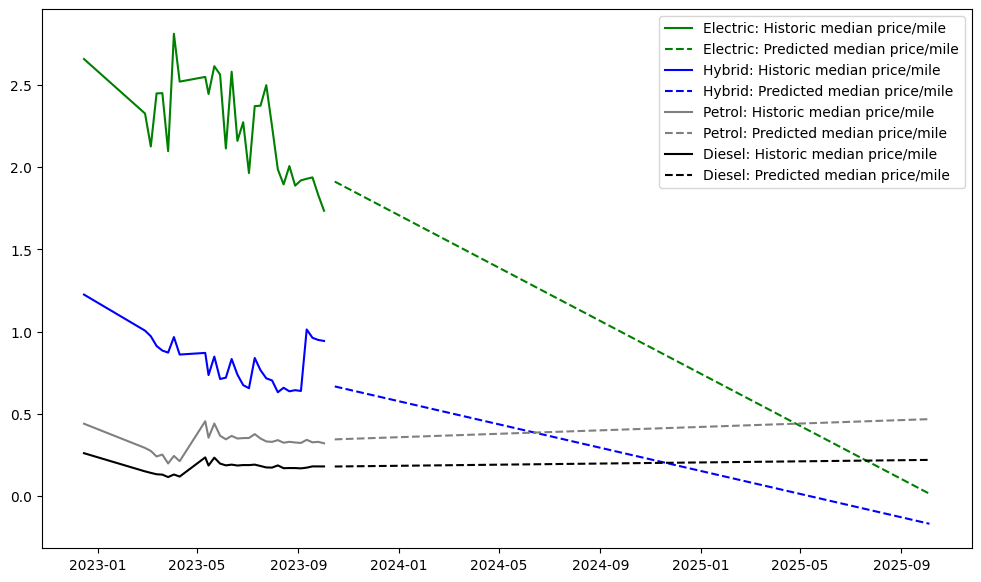

In [40]:
# Plot 'median_price_per_mile' predictions.
plt.figure(figsize=(12, 7))

plt.plot(df_mr_electric['date'], df_mr_electric['median_price_per_mile'], color='green', label='Electric: Historic median price/mile')
plt.plot(electric_tsa_median_price_per_mile['date'], electric_tsa_median_price_per_mile['median_price_per_mile'], '--', color='green', label='Electric: Predicted median price/mile')

plt.plot(df_mr_hybrid['date'], df_mr_hybrid['median_price_per_mile'], color='blue', label='Hybrid: Historic median price/mile')
plt.plot(hybrid_tsa_median_price_per_mile['date'], hybrid_tsa_median_price_per_mile['median_price_per_mile'], '--', color='blue', label='Hybrid: Predicted median price/mile')

plt.plot(df_mr_petrol['date'], df_mr_petrol['median_price_per_mile'], color='grey', label='Petrol: Historic median price/mile')
plt.plot(petrol_tsa_median_price_per_mile['date'], petrol_tsa_median_price_per_mile['median_price_per_mile'], '--', color='grey', label='Petrol: Predicted median price/mile')

plt.plot(df_mr_diesel['date'], df_mr_diesel['median_price_per_mile'], color='black', label='Diesel: Historic median price/mile')
plt.plot(diesel_tsa_median_price_per_mile['date'], diesel_tsa_median_price_per_mile['median_price_per_mile'], '--', color='black', label='Diesel: Predicted median price/mile')

plt.legend()
plt.show()

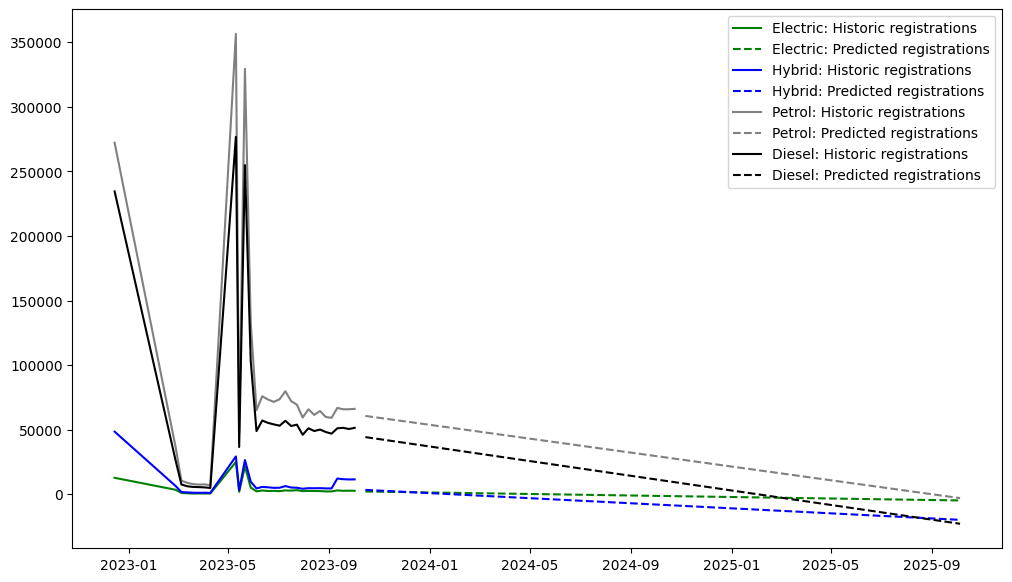

In [41]:
# Plot 'registrations' predictions.
plt.figure(figsize=(12, 7))

plt.plot(df_mr_electric['date'], df_mr_electric['registrations'], color='green', label='Electric: Historic registrations')
plt.plot(electric_tsa_registrations['date'], electric_tsa_registrations['registrations'], '--', color='green', label='Electric: Predicted registrations')

plt.plot(df_mr_hybrid['date'], df_mr_hybrid['registrations'], color='blue', label='Hybrid: Historic registrations')
plt.plot(hybrid_tsa_registrations['date'], hybrid_tsa_registrations['registrations'], '--', color='blue', label='Hybrid: Predicted registrations')

plt.plot(df_mr_petrol['date'], df_mr_petrol['registrations'], color='grey', label='Petrol: Historic registrations')
plt.plot(petrol_tsa_registrations['date'], petrol_tsa_registrations['registrations'], '--', color='grey', label='Petrol: Predicted registrations')

plt.plot(df_mr_diesel['date'], df_mr_diesel['registrations'], color='black', label='Diesel: Historic registrations')
plt.plot(diesel_tsa_registrations['date'], diesel_tsa_registrations['registrations'], '--', color='black', label='Diesel: Predicted registrations')

plt.legend()
plt.show()

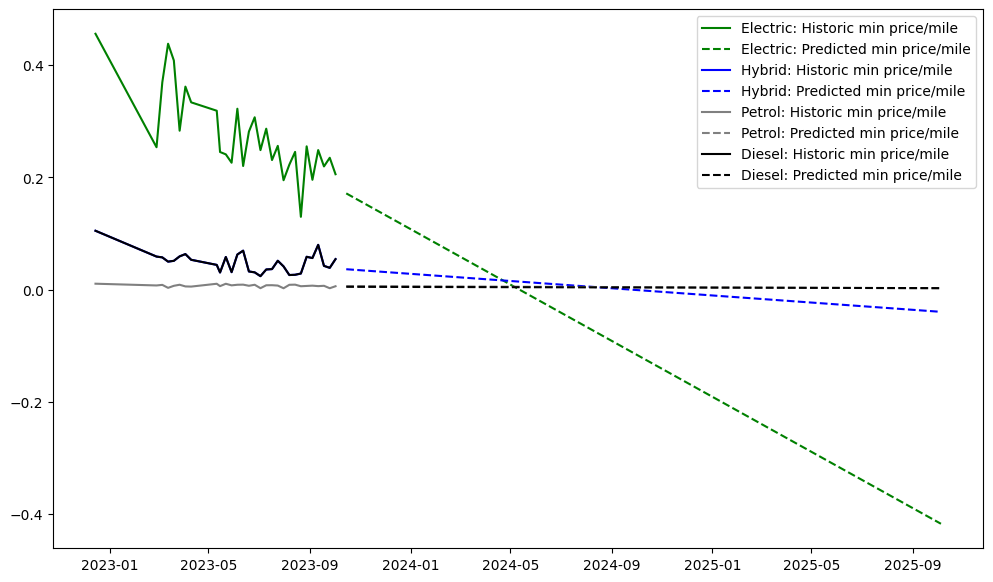

In [42]:
# Plot 'min_price_per_mile' predictions.
plt.figure(figsize=(12, 7))

plt.plot(df_mr_electric['date'], df_mr_electric['min_price_per_mile'], color='green', label='Electric: Historic min price/mile')
plt.plot(electric_tsa_min_price_per_mile['date'], electric_tsa_min_price_per_mile['min_price_per_mile'], '--', color='green', label='Electric: Predicted min price/mile')

plt.plot(df_mr_hybrid['date'], df_mr_hybrid['min_price_per_mile'], color='blue', label='Hybrid: Historic min price/mile')
plt.plot(hybrid_tsa_min_price_per_mile['date'], hybrid_tsa_min_price_per_mile['min_price_per_mile'], '--', color='blue', label='Hybrid: Predicted min price/mile')

plt.plot(df_mr_petrol['date'], df_mr_petrol['min_price_per_mile'], color='grey', label='Petrol: Historic min price/mile')
plt.plot(petrol_tsa_min_price_per_mile['date'], petrol_tsa_min_price_per_mile['min_price_per_mile'], '--', color='grey', label='Petrol: Predicted min price/mile')

plt.plot(df_mr_hybrid['date'], df_mr_hybrid['min_price_per_mile'], color='black', label='Diesel: Historic min price/mile')
plt.plot(diesel_tsa_min_price_per_mile['date'], diesel_tsa_min_price_per_mile['min_price_per_mile'], '--', color='black', label='Diesel: Predicted min price/mile')

plt.legend()
plt.show()

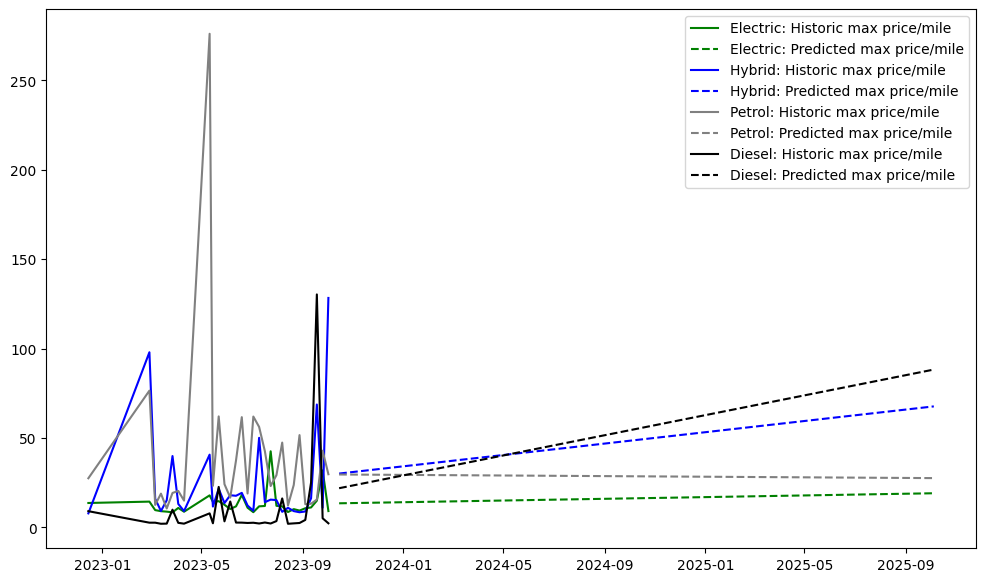

In [43]:
# Plot 'max_price_per_mile' predictions.
plt.figure(figsize=(12, 7))

plt.plot(df_mr_electric['date'], df_mr_electric['max_price_per_mile'], color='green', label='Electric: Historic max price/mile')
plt.plot(electric_tsa_max_price_per_mile['date'], electric_tsa_max_price_per_mile['max_price_per_mile'], '--', color='green', label='Electric: Predicted max price/mile')

plt.plot(df_mr_hybrid['date'], df_mr_hybrid['max_price_per_mile'], color='blue', label='Hybrid: Historic max price/mile')
plt.plot(hybrid_tsa_max_price_per_mile['date'], hybrid_tsa_max_price_per_mile['max_price_per_mile'], '--', color='blue', label='Hybrid: Predicted max price/mile')

plt.plot(df_mr_petrol['date'], df_mr_petrol['max_price_per_mile'], color='grey', label='Petrol: Historic max price/mile')
plt.plot(petrol_tsa_max_price_per_mile['date'], petrol_tsa_max_price_per_mile['max_price_per_mile'], '--', color='grey', label='Petrol: Predicted max price/mile')

plt.plot(df_mr_diesel['date'], df_mr_diesel['max_price_per_mile'], color='black', label='Diesel: Historic max price/mile')
plt.plot(diesel_tsa_max_price_per_mile['date'], diesel_tsa_max_price_per_mile['max_price_per_mile'], '--', color='black', label='Diesel: Predicted max price/mile')

plt.legend()
plt.show()

In [44]:
# Create DataFrames for the predictions of each independent variable.
future_dates = pd.date_range(start=latest_date, freq='W', periods=105)[1:]
future_days_from_start = [(date - start_date).days for date in future_dates]

df_electric_independent_vars = pd.DataFrame({
    'days_since_start': future_days_from_start,
    'registrations': electric_tsa_registrations['registrations'],
    'median_price_per_mile': electric_tsa_median_price_per_mile['median_price_per_mile'],
    'min_price_per_mile': electric_tsa_min_price_per_mile['min_price_per_mile'],
    'max_price_per_mile': electric_tsa_max_price_per_mile['max_price_per_mile'],
})
df_hybrid_independent_vars = pd.DataFrame({
    'days_since_start': future_days_from_start,
    'registrations': hybrid_tsa_registrations['registrations'],
    'median_price_per_mile': hybrid_tsa_median_price_per_mile['median_price_per_mile'],
    'min_price_per_mile': hybrid_tsa_min_price_per_mile['min_price_per_mile'],
    'max_price_per_mile': hybrid_tsa_max_price_per_mile['max_price_per_mile'],
})
df_petrol_independent_vars = pd.DataFrame({
    'days_since_start': future_days_from_start,
    'registrations': petrol_tsa_registrations['registrations'],
    'median_price_per_mile': petrol_tsa_median_price_per_mile['median_price_per_mile'],
    'min_price_per_mile': petrol_tsa_min_price_per_mile['min_price_per_mile'],
    'max_price_per_mile': petrol_tsa_max_price_per_mile['max_price_per_mile'],
})
df_diesel_independent_vars = pd.DataFrame({
    'days_since_start': future_days_from_start,
    'registrations': diesel_tsa_registrations['registrations'],
    'median_price_per_mile': diesel_tsa_median_price_per_mile['median_price_per_mile'],
    'min_price_per_mile': diesel_tsa_min_price_per_mile['min_price_per_mile'],
    'max_price_per_mile': diesel_tsa_max_price_per_mile['max_price_per_mile'],
})

In [45]:
# Predict future median prices from predicted independent variables.
df_pred_electric = regression_electric.predict(df_electric_independent_vars)
df_pred_hybrid = regression_hybrid.predict(df_hybrid_independent_vars)
df_pred_petrol = regression_petrol.predict(df_petrol_independent_vars)
df_pred_diesel = regression_diesel.predict(df_diesel_independent_vars)

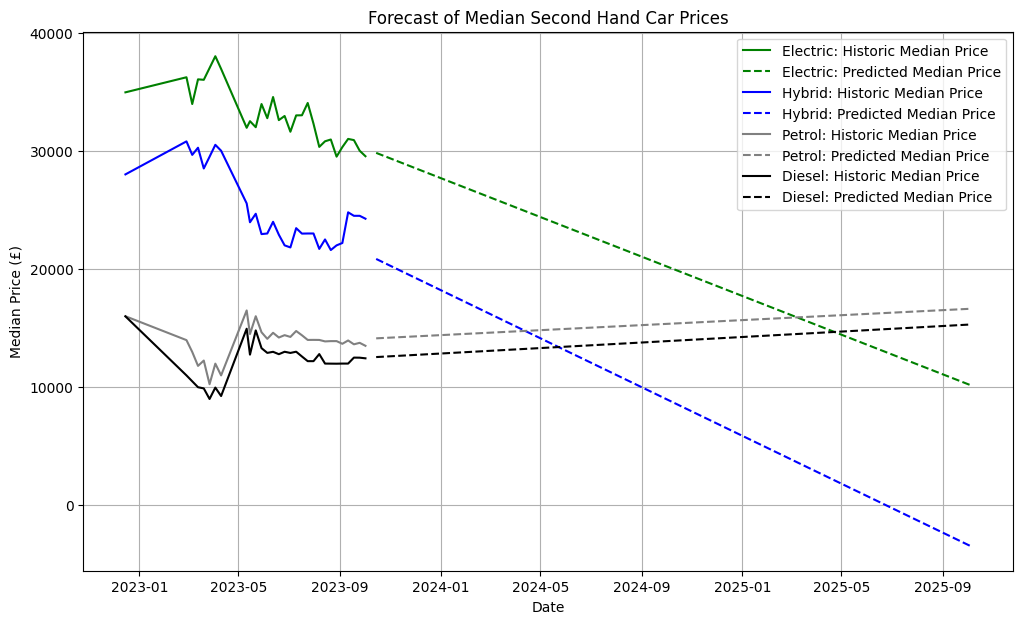

In [46]:
# Plot the predicted median prices.
plt.figure(figsize=(12, 7))

plt.plot(df_mr_electric['date'], df_mr_electric['median_price'], color='green', label='Electric: Historic Median Price')
plt.plot(future_dates, df_pred_electric, '--', color='green', label='Electric: Predicted Median Price')

plt.plot(df_mr_hybrid['date'], df_mr_hybrid['median_price'], color='blue', label='Hybrid: Historic Median Price')
plt.plot(future_dates, df_pred_hybrid, '--', color='blue', label='Hybrid: Predicted Median Price')

plt.plot(df_mr_petrol['date'], df_mr_petrol['median_price'], color='grey', label='Petrol: Historic Median Price')
plt.plot(future_dates, df_pred_petrol, '--', color='grey', label='Petrol: Predicted Median Price')

plt.plot(df_mr_diesel['date'], df_mr_diesel['median_price'], color='black', label='Diesel: Historic Median Price')
plt.plot(future_dates, df_pred_diesel, '--', color='black', label='Diesel: Predicted Median Price')

plt.xlabel(xlabel='Date')
plt.ylabel(ylabel='Median Price (£)')
plt.title('Forecast of Median Second Hand Car Prices')

plt.grid(True)
plt.legend()
plt.show()

#### Considerations:

Possible reasons for an earlier price parity:
 - Increasing up-take of EVs will only increase the number of EVs in the second hand market,
 - With increasing demand OEMs may be able to reduce prices by varying degrees, it is worth noting that around the time Tesla dropped the prices of their models vehicles with electrified drive trains saw a drop in median price in the second hand market (correlation is not causation, however),
 - Generally the older a car is, the less it will be sold on for, EVs have been on the market for an increasingly long time and so we could see this 'age tax' on older cars become more common on electric cars,
 - If drivers flock to second hand ICE cars to avoid transitioning, or at least to stall transitioning, EVs could see a price drop as demand falls below supply (I personally think this is unlikely),

Possible reasons for later price parity:
 - With demand for leasing vehicles going up, especially with EVs, this could effect how we recognise second hand vehicles, i.e. re-leasing rather than re-selling, so supply might not keep up with demand
 